In [1]:
import h5py as h5

import itertools
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy import (coordinates as coord, units as u)
from astropy.coordinates.matrix_utilities import (matrix_product, rotation_matrix)
from tqdm import tqdm
from scipy import (optimize as op)
from astropy import constants

from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.collections import LineCollection


import sys
sys.path.insert(0, "../code")
from mpl_utils import mpl_style

import twobody

plt.style.use(mpl_style)


np.random.seed(0)

%matplotlib inline

In [156]:


# Functions:
# (1) Approximate the astrometric RMS by ignoring inclination, sky distortian, etc.
# (2) Exactly calculate the astrometric RMS.

def approximate_ruwe(t, P, m1, m2, distance, f1=None, f2=None, t0=None, 
                     i=0*u.deg, **kwargs):
    """
    Approximate the on-sky astrometric excess noise for a binary system with the
    given system parameters at a certain distance.

    This approximating function ignores the following effects:

    (1) The distortions that arise due to sky projections.
    (2) Inclination effects.
    (3) Omega effects.

    In part it also assumes:

    (1) The times were observed pseudo-randomly.
    (2) The orbit is fully sampled.

    :param t:
        The times that the system was observed.

    :param P:
        The period of the binary system.

    :param m1:
        The mass of the primary star.

    :param m2:
        The mass of the secondary system.

    :param distance:
        The distance from the observer to the center of mass of the binary
        system.

    :param f1: [optional]
        The flux of the primary star. If `None` is given then this is assumed to
        be $m_1^{3.5}$.

    :param f2: [optional]
        The flux of the secondary. If `None` is given then this is assumed to be
        $m_2^{3.5}$.

    :returns:
        A two-part tuple containing the root-mean-squared deviations in on-sky
        position (in units of milliarcseconds), and a dictionary containing meta
        information about the binary system.
    """

    if f1 is None:
        f1 = m1.to(u.solMass).value**3.5
    if f2 is None:
        f2 = m2.to(u.solMass).value**3.5

    if t0 is None:
        t0 = Time('J2015.5')

    m_total = m1 + m2
    w = np.array([f1, f2])/(f1 + f2)
    a = twobody.P_m_to_a(P, m_total).to(u.AU).value

    a1 = m2 * a / m_total
    a2 = m1 * a / m_total

    w1, w2 = (w[0], w[1])

    # TODO: replace this with integral!
    dt = (t - t0).to(u.day)
    phi = (2 * np.pi * dt / P).value
    N = phi.size

    dx = a1 * w1 * np.cos(phi) + a2 * w2 * np.cos(phi + np.pi)
    dy = a1 * w1 * np.sin(phi) + a2 * w2 * np.sin(phi + np.pi)

    planar_rms_in_au = np.sqrt(np.sum((dx - np.mean(dx))**2 + (dy - np.mean(dy))**2)/N).value

    # Need some corrections for when the period is longer than the observing timespan, and the
    # inclination angle is non-zero.

    # For this it really depends on what t0/Omega is: if you see half the orbit in one phase or
    # another...
    # TODO: this requires a thinko.
    

    """
    Approximate given some inclination angle.
    At zero inclination, assume circle on sky such that:
    
        rms = sqrt(ds^2 + ds^2) = sqrt(2ds^2)

    and 
        
        ds = np.sqrt(0.5 * rms^2)

    Now when inclined (even at 90) we still get ds + contribution:

        rms_new = sqrt(ds^2 + (cos(i) * ds)^2)
    """

    ds = np.sqrt(0.5 * planar_rms_in_au**2)
    rms_in_au = np.sqrt(ds**2 + (np.cos(i) * ds)**2)
    rms_in_mas = (rms_in_au * u.au / distance).to(u.mas, equivalencies=u.dimensionless_angles())

    # Intrinsic error on position in one direction is.
    # These are the final values. The individual epochs are probably about a 10th of this.
    intrinsic_ra_error = 0.029 # mas
    intrinsic_dec_error = 0.026 # mas

    intrinsic_ra_error /= 10
    intrinsic_dec_error /= 10

    chi2 = N * rms_in_mas.to(u.mas).value**2 / (intrinsic_ra_error**2 + intrinsic_dec_error**2)

    # sqrt(2) from approximating rms in one dimension instead of 2
    approx_ruwe = np.sqrt(2) * np.sqrt(chi2/(N - 2))
    
    meta = dict(weights=w,
                a=a,
                a1=a1,
                a2=a2,
                w1=w1,
                w2=w2,
                phi=phi,
                dx=dx,
                dy=dy,
                rms_in_au=rms_in_au)

    return (approx_ruwe, meta)


def astrometric_excess_noise(t, P, m1, m2, f1=None, f2=None, e=0, t0=None,
                             omega=0*u.deg, i=0*u.deg, Omega=0*u.deg, 
                             origin=None, **kwargs):
    """
    Calculate the astrometric excess noise for a binary system with given
    properties that was observed at certain times from the given origin position.
    
    # TODO: There are a number of assumptions that we look over here

    :param t:
        The times that the system was observed.

    :param P:
        The period of the binary system.

    :param m1:
        The mass of the primary body.

    :param m2:
        The mass of the secondary body.

    :param f1: [optional]
        The flux of the primary body. If `None` is given then $M_1^{3.5}$ will
        be assumed.

    :param f2: [optional]
        The flux of the secondary body. If `None` is given then $M_2^{3.5}$ will
        be assumed.

    :param e: [optional]
        The eccentricity of the system (default: 0).

    # TODO: more docs pls
    """


    # TODO: Re-factor this behemoth by applying the weights after calculating positions?
    if f1 is None:
        f1 = m1.to(u.solMass).value**3.5
    if f2 is None:
        f2 = m2.to(u.solMass).value**3.5

    if t0 is None:
        t0 = Time('J2015.5')

    N = t.size
    
    # Compute orbital positions.
    with u.set_enabled_equivalencies(u.dimensionless_angles()):
        M1 = (2*np.pi * (t.tcb - t0.tcb) / P).to(u.radian)
        # Set secondary to have opposite phase.
        M2 = (2*np.pi * (t.tcb - t0.tcb) / P - np.pi).to(u.radian)
        
    # eccentric anomaly
    E1 = twobody.eccentric_anomaly_from_mean_anomaly(M1, e)
    E2 = twobody.eccentric_anomaly_from_mean_anomaly(M2, e)

    # mean anomaly
    F1 = twobody.true_anomaly_from_eccentric_anomaly(E1, e)
    F2 = twobody.true_anomaly_from_eccentric_anomaly(E2, e)

    # Calc a1/a2.
    m_total = m1 + m2
    a = twobody.P_m_to_a(P, m_total)
    a1 = m2 * a / m_total
    a2 = m1 * a / m_total

    r1 = (a1 * (1. - e * np.cos(E1))).to(u.au).value
    r2 = (a2 * (1. - e * np.cos(E2))).to(u.au).value

    # Calculate xy positions in orbital plane.
    x = np.vstack([
        r1 * np.cos(F1),
        r2 * np.cos(F2),
    ]).value
    y = np.vstack([
        r1 * np.sin(F1),
        r2 * np.sin(F2)
    ]).value

    # Calculate photocenter in orbital plane.
    w = np.atleast_2d([f1, f2])/(f1 + f2)
    x, y = np.vstack([w @ x, w @ y])
    z = np.zeros_like(x)

    # Calculate photocenter velocities in orbital plane.
    fac = (2*np.pi * a / P / np.sqrt(1 - e**2)).to(u.au/u.s).value
    vx = np.vstack([
        -fac * np.sin(F1),
        -fac * np.sin(F2)
    ]).value
    vy = np.vstack([
        fac * (np.cos(F1) + e),
        fac * (np.cos(F2) + e)
    ]).value
    vx, vy = np.vstack([w @ vx, w @ vy])
    vz = np.zeros_like(vx)

    # TODO: handle units better w/ dot product
    x, y, z = (x * u.au, y * u.au, z * u.au)
    vx, vy, vz = (vx * u.au/u.s, vy * u.au/u.s, vz * u.au/u.s)
    
    xyz = coord.CartesianRepresentation(x=x, y=y, z=z)
    vxyz = coord.CartesianDifferential(d_x=vx, d_y=vy, d_z=vz)
    xyz = xyz.with_differentials(vxyz)

    vxyz = xyz.differentials["s"]
    xyz = xyz.without_differentials()

    # Construct rotation matrix from orbital plane system to reference plane system.
    R1 = rotation_matrix(-omega, axis='z')
    R2 = rotation_matrix(i, axis='x')
    R3 = rotation_matrix(Omega, axis='z')
    Rot = matrix_product(R3, R2, R1)

    # Rotate photocenters to the reference plane system.
    XYZ = coord.CartesianRepresentation(matrix_product(Rot, xyz.xyz))
    VXYZ = coord.CartesianDifferential(matrix_product(Rot, vxyz.d_xyz))
    XYZ = XYZ.with_differentials(VXYZ)

    barycenter = twobody.Barycenter(origin=origin, t0=t0)
    kw = dict(origin=barycenter.origin)
    rp = twobody.ReferencePlaneFrame(XYZ, **kw)

    # Calculate the ICRS positions.
    icrs_cart = rp.transform_to(coord.ICRS).cartesian
    icrs_pos = icrs_cart.without_differentials()
    icrs_vel = icrs_cart.differentials["s"]

    bary_cart = barycenter.origin.cartesian
    bary_vel = bary_cart.differentials["s"]

    dt = t - barycenter.t0
    dx = (bary_vel * dt).to_cartesian()

    pos = icrs_pos + dx
    vel = icrs_vel + bary_vel

    icrs = coord.ICRS(pos.with_differentials(vel))

    positions = np.array([icrs.ra.deg, icrs.dec.deg])

    mean_position = np.mean(positions, axis=1)
    assert mean_position.size == 2
    '''
    intrinsic_ra_error = 0.029 # mas
    intrinsic_dec_error = 0.026 # mas

    intrinsic_ra_error /= 10
    intrinsic_dec_error /= 10

    chi2 = N * rms_in_mas.to(u.mas).value**2 / np.sqrt(intrinsic_ra_error**2 + intrinsic_dec_error**2)

    approx_ruwe = np.sqrt(chi2/(N - 2))
    '''
    
    
    intrinsic_ra_error = 0.029 # mas
    intrinsic_dec_error = 0.026 # mas

    intrinsic_ra_error /= 10
    intrinsic_dec_error /= 10

    
    # Calculate on sky RMS.

    astrometric_rms = np.sqrt(np.sum((positions.T - mean_position)**2)/N)
    astrometric_rms *= u.deg
    
    diff = ((positions.T - mean_position) * u.deg).to(u.mas)
    #chi2 = diff**2 / (intrinsic_ra_error**2 + intrinsic_dec_error**2)
    ruwe = np.sqrt(np.sum((diff.T[0]/intrinsic_ra_error)**2 + (diff.T[1]/intrinsic_dec_error)**2)/(N-2)).value
        
    meta = dict()
    return (ruwe, meta)
    #return (astrometric_rms, meta)


# NOW BURN FORESTS

  0%|          | 0/100 [00:00<?, ?it/s]

Simulating binary systems...


100%|██████████| 100/100 [04:28<00:00,  2.49s/it]


Plotting using expensive AEN -- doing comparisons


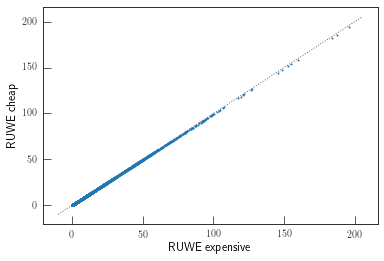

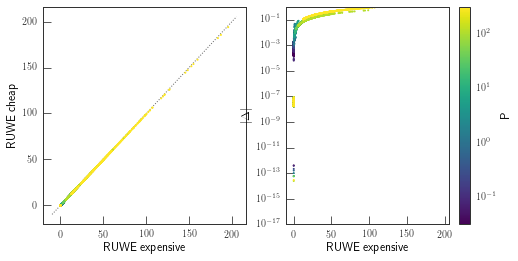

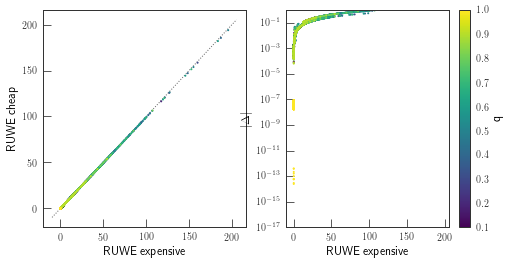

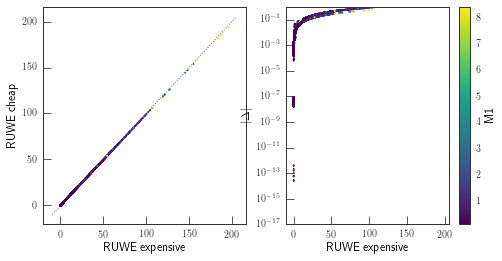

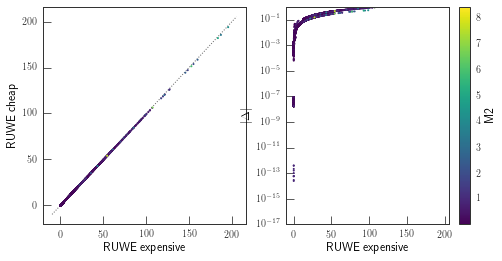

In [158]:

# From https://www.cosmos.esa.int/web/gaia/dr2
obs_start = Time('2014-07-25T10:30')
obs_end = Time('2016-05-23T11:35')
observing_span = obs_end - obs_start


# Put the sky position something where it will not wrap...
# Also you should set RV = 0 and proper motion as zero because here we assume that
# the contribution of those factors has been accounted for by Gaia
origin = coord.ICRS(ra=0.1 * u.deg,
                    dec=0.1 * u.deg,
                    distance=1000 * u.pc,
                    pm_ra_cosdec=0 * u.mas/u.yr,
                    pm_dec=0 * u.mas/u.yr,
                    radial_velocity=0 * u.km/u.s)
kwds = dict(i=0 * u.deg, omega=0 * u.deg, origin=origin)

"""
if kwds["i"] > (0 * u.deg):
    print("Warning: approximate AEN calculations currently ignore inclination.")

if kwds["pm_ra_cosdec"] > (0 * u.mas/u.yr) \
or kwds["pm_dec"] > (0 * u.mas/u.yr):
    print("Warning: proper motion should be zero as we assume Gaia has accounted for this")
"""  

def salpeter_imf(N, alpha, M_min, M_max):
    log_M_limits = np.log([M_min, M_max])

    max_ll = M_min**(1.0 - alpha)

    M = []
    while len(M) < N:
        Mi = np.exp(np.random.uniform(*log_M_limits))

        ln = Mi**(1 - alpha)
        if np.random.uniform(0, max_ll) < ln:
            M.append(Mi)

    return np.array(M)



N_repeats = 100
Ms = salpeter_imf(N_repeats, 2.35, 0.1, 100) * u.solMass

# Get the number of astrometric obs.
with h5.File("../data/sources.hdf5", "r") as sources:
    astrometric_n_good_obs_al = np.random.choice(sources["sources"]["astrometric_n_good_obs_al"], N_repeats)

#astrometric_n_good_obs_al = (225 * np.ones(N_repeats)).astype(int)


BURN_FORESTS = True
PROCESSES = 1

q_bins, P_bins = (10, 10)
Ps = np.logspace(-1.5, 2.5, P_bins)
qs = np.linspace(0.1, 1, q_bins)

qPs = np.array(list(itertools.product(qs, Ps)))

ruwe = np.zeros((qPs.shape[0], N_repeats), dtype=float)
approx_ruwe = np.zeros((qPs.shape[0], N_repeats), dtype=float)

extras = np.zeros((qPs.shape[0], N_repeats, 4), dtype=float)

assert max(Ps) < observing_span.to(u.day).value

def _mp_approx_ruwe(i, j, kw):
    v, meta = approximate_ruwe(**kw)
    return (i, j, v)

def _mp_actual_aen(i, j, kw):
    v, meta = astrometric_excess_noise(**kw)
    return (i, j, v.to(u.mas).value)


if PROCESSES > 1:
    pool = mp.Pool(processes=PROCESSES)

    p_approx = []
    p_actual = []

print("Simulating binary systems...")

for i, (q, P) in enumerate(tqdm(qPs)):

    P = P * u.day

    for j, (m1, N) in enumerate(zip(Ms, astrometric_n_good_obs_al)):
        
        t = obs_start + np.linspace(0, 1, N) * (obs_end - obs_start)
        m2 = q * m1

        kw = kwds.copy()
        kw.update(t=t, 
                  P=P,
                  m1=m1, m2=m2,
                  f1=m1.to(u.solMass).value**3.5, f2=m2.to(u.solMass).value**3.5,
                  # This gets ignored by astrometric_excess_noise but is needed for approximations
                  distance=origin.distance)

        v = [P.value, q, m1.value, m2.value]
        extras[i, j, :len(v)] = v

        if PROCESSES > 1:
            p_approx.append(pool.apply_async(_mp_approx_ruwe, (i, j, kw)))

            if BURN_FORESTS:
                p_actual.append(pool.apply_async(_mp_actual_aen, (i, j, kw)))

        else:
            #approx_rms, approx_meta = approximate_ruwe(**kw)
            r, approx_meta = approximate_ruwe(**kw)
            # TODO: Don't take RMS == AEN! They are different!
            #approx_aen[i, j] = approx_rms.to(u.mas).value        

            approx_ruwe[i, j] = r
           
            if BURN_FORESTS:
                actual_aen, actual_meta = astrometric_excess_noise(**kw)
                #ruwe[i, j] = np.sqrt(actual_aen.to(u.mas).value/(len(kw["t"]) - 2))
                ruwe[i, j] = actual_aen#.to(u.deg).value
    
        foo, bar = ruwe[i, j], approx_ruwe[i, j]
        
                
if PROCESSES > 1:

    print("Collecting results")
    for each in tqdm(p_approx):
        i, j, v = each.get(timeout=1)
        approx_ruwe[i, j] = v

    for each in p_actual:
        i, j, v = each.get(timeout=1)
        aen[i, j] = v

    pool.close()
    pool.join()


if not BURN_FORESTS:
    print("Using AEN approximations")
    #aen = approx_aen
    ruwe = approx_ruwe

else:
    print("Plotting using expensive AEN -- doing comparisons")

    fig, ax = plt.subplots()
    ax.scatter(ruwe.flatten(), approx_ruwe.flatten(), s=1)

    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1, ms=0, lw=1)
    ax.set_xlabel(r"{RUWE expensive}")
    ax.set_ylabel(r"{RUWE cheap}")

    options = [
        ("P", True),
        ("q", False),
        ("M1", False),
        ("M2", False)
    ]

    abs_diff = np.abs(ruwe - approx_ruwe)

    for i, (label, is_norm) in enumerate(options):


        kw = dict(s=1, c=extras[:, :, i].flatten())
        if is_norm:
            kw.update(norm=LogNorm())

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        ax = axes[0]
        ax.scatter(ruwe.flatten(), approx_ruwe.flatten(), **kw)
        ax.set_xlabel(r"{RUWE expensive}")
        ax.set_ylabel(r"{RUWE cheap}")

        limits = np.array([ax.get_xlim(), ax.get_ylim()])
        limits = (np.min(limits), np.max(limits))
        ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1, ms=0, lw=1)

        ax = axes[1]
        scat = ax.scatter(ruwe.flatten(), abs_diff.flatten(), **kw)
        ax.semilogy()
        ax.set_ylim(10**-17, 10**-0)

        cbar = plt.colorbar(scat)
        cbar.set_label(label)

        ax.set_xlabel(r"{RUWE expensive}")
        ax.set_ylabel(r"$|\Delta|$")


if not BURN_FORESTS:

    mean_ruwe = np.mean(ruwe, axis=1).reshape((q_bins, P_bins))

    # Plot per Q first.
    cmap = cm.viridis(qs)
    fig, ax = plt.subplots()

    lc = LineCollection([np.column_stack([Ps, mr]) for mr in mean_ruwe])

    lc.set_array(np.asarray(qs))
    ax.add_collection(lc)
    ax.autoscale()


    #    print(i, q, np.mean(mean_aen[i]))
    cbar = plt.colorbar(lc)
    cbar.set_label(r"$q$")



    ax.set_xlabel(r"{period / days}$^{-1}$")
    ax.set_ylabel(r"{RUWE}")
    ax.semilogx()

    v = (obs_end - obs_start).to(u.day).value
    axvline_kwds = dict(c="#666666", zorder=-1, lw=1, ms=1)
    ax.axvline(v, linestyle=":", **axvline_kwds)
    ax.axvline(2 * v, linestyle="-", **axvline_kwds)


    print(kwds)


    qm, Pm = np.meshgrid(qs, Ps)

    contourf_kwds = dict(cmap="magma", norm=LogNorm(), levels=None)

    fig, ax = plt.subplots()
    im = ax.contourf(Ps, qs, mean_ruwe, **contourf_kwds)
    ax.semilogx()


    ax.set_xlabel(r"{period / days}$^{-1}$")
    ax.set_ylabel(r"$q$")

    cbar = plt.colorbar(im)
    cbar.set_label(r"{RUWE / mas}")

    fig.tight_layout()

    axvline_kwds.update(zorder=10)

    ax.axvline(v, linestyle=":", **axvline_kwds)
    ax.axvline(2 * v, linestyle="-", **axvline_kwds)


    print(kwds)


    # Let's do a simple thing about detector efficiency.
    # Let's assume anything more than 0.1 umas RMS is a detected binary.
    #detected = (aen >= (0.1 * u.mas).value).astype(int)
    detected = (ruwe >= 1.5).astype(int)

    de = np.mean(detected, axis=1).reshape((q_bins, P_bins))


    N_levels = 10
    contourf_kwds = dict(cmap="Blues", norm=LogNorm(), levels=np.logspace(-1, 0, N_levels + 1))
    contourf_kwds = dict(cmap="Blues",levels=np.linspace(0, 1, N_levels + 1))


    fig, ax = plt.subplots()
    im = ax.contourf(Ps, qs, de, **contourf_kwds)
    ax.semilogx()

    cbar = plt.colorbar(im)
    cbar.set_label(r"{detection efficiency}")

    ax.set_xlabel(r"{period / days}$^{-1}$")
    ax.set_ylabel(r"$q$")

    fig.tight_layout()

    # Show the observing span and twice that.
    axvline_kwds = dict(c="#000000", zorder=10, lw=1, ms=0)
    ax.axvline(observing_span.to(u.day).value, linestyle=":", **axvline_kwds)
    ax.axvline(2 * observing_span.to(u.day).value, linestyle="-", **axvline_kwds)



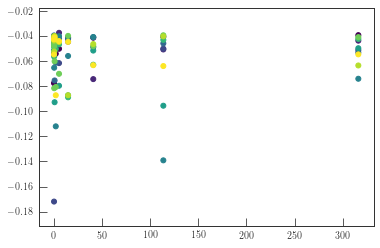

In [165]:
X, Y = (np.mean(ruwe, axis=0), np.mean(approx_ruwe, axis=0))
fig, ax = plt.subplots()
ax.scatter(qPs.T[1], Y-X, c=qPs.T[0])


(-0.5, 10)

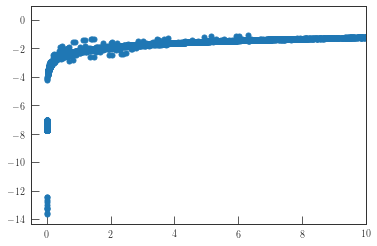

In [170]:
fig, ax = plt.subplots()
ax.scatter(ruwe.flatten(), np.log10(np.abs(ruwe - approx_ruwe).flatten()))
ax.set_xlim(-0.5, 10)

# OK, now let's include longer periods.


  0%|          | 0/400 [00:00<?, ?it/s]

Simulating binary systems...


100%|██████████| 400/400 [04:55<00:00,  1.35it/s]


Plotting using expensive AEN -- doing comparisons


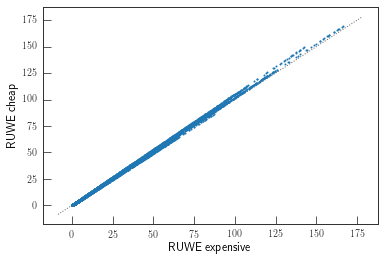

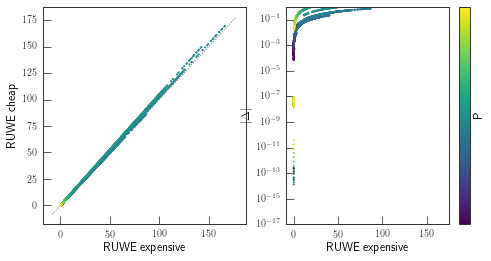

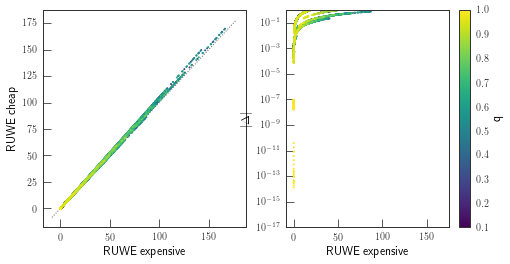

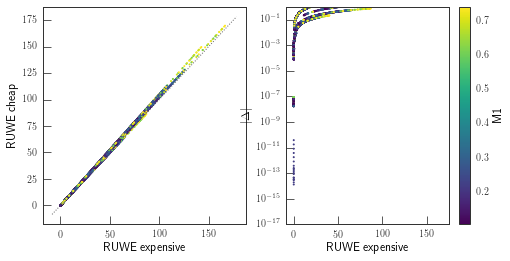

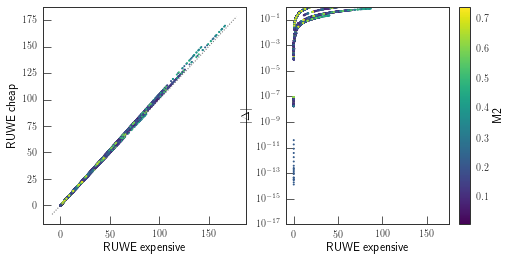

In [199]:

# From https://www.cosmos.esa.int/web/gaia/dr2
obs_start = Time('2014-07-25T10:30')
obs_end = Time('2016-05-23T11:35')
observing_span = obs_end - obs_start


# Put the sky position something where it will not wrap...
# Also you should set RV = 0 and proper motion as zero because here we assume that
# the contribution of those factors has been accounted for by Gaia
origin = coord.ICRS(ra=0.1 * u.deg,
                    dec=0.1 * u.deg,
                    distance=1000 * u.pc,
                    pm_ra_cosdec=0 * u.mas/u.yr,
                    pm_dec=0 * u.mas/u.yr,
                    radial_velocity=0 * u.km/u.s)
kwds = dict(i=0 * u.deg, omega=0 * u.deg, origin=origin)

"""
if kwds["i"] > (0 * u.deg):
    print("Warning: approximate AEN calculations currently ignore inclination.")

if kwds["pm_ra_cosdec"] > (0 * u.mas/u.yr) \
or kwds["pm_dec"] > (0 * u.mas/u.yr):
    print("Warning: proper motion should be zero as we assume Gaia has accounted for this")
"""  

def salpeter_imf(N, alpha, M_min, M_max):
    log_M_limits = np.log([M_min, M_max])

    max_ll = M_min**(1.0 - alpha)

    M = []
    while len(M) < N:
        Mi = np.exp(np.random.uniform(*log_M_limits))

        ln = Mi**(1 - alpha)
        if np.random.uniform(0, max_ll) < ln:
            M.append(Mi)

    return np.array(M)



N_repeats = 30
Ms = salpeter_imf(N_repeats, 2.35, 0.1, 100) * u.solMass

# Get the number of astrometric obs.
with h5.File("../data/sources.hdf5", "r") as sources:
    astrometric_n_good_obs_al = np.random.choice(sources["sources"]["astrometric_n_good_obs_al"], N_repeats)

#astrometric_n_good_obs_al = (225 * np.ones(N_repeats)).astype(int)


BURN_FORESTS = True
PROCESSES = 1

q_bins, P_bins = (20, 20)
Ps = np.logspace(-1.5, 8, P_bins)
qs = np.linspace(0.1, 1, q_bins)

qPs = np.array(list(itertools.product(qs, Ps)))

ruwe = np.zeros((qPs.shape[0], N_repeats), dtype=float)
approx_ruwe = np.zeros((qPs.shape[0], N_repeats), dtype=float)

extras = np.zeros((qPs.shape[0], N_repeats, 4), dtype=float)

#assert max(Ps) < observing_span.to(u.day).value

def _mp_approx_ruwe(i, j, kw):
    v, meta = approximate_ruwe(**kw)
    return (i, j, v)

def _mp_actual_aen(i, j, kw):
    v, meta = astrometric_excess_noise(**kw)
    return (i, j, v.to(u.mas).value)


if PROCESSES > 1:
    pool = mp.Pool(processes=PROCESSES)

    p_approx = []
    p_actual = []

print("Simulating binary systems...")

for i, (q, P) in enumerate(tqdm(qPs)):

    P = P * u.day

    for j, (m1, N) in enumerate(zip(Ms, astrometric_n_good_obs_al)):
        
        t = obs_start + np.linspace(0, 1, N) * (obs_end - obs_start)
        m2 = q * m1

        kw = kwds.copy()
        kw.update(t=t, 
                  P=P,
                  m1=m1, m2=m2,
                  f1=m1.to(u.solMass).value**3.5, f2=m2.to(u.solMass).value**3.5,
                  # This gets ignored by astrometric_excess_noise but is needed for approximations
                  distance=origin.distance)

        v = [P.value, q, m1.value, m2.value]
        extras[i, j, :len(v)] = v

        if PROCESSES > 1:
            p_approx.append(pool.apply_async(_mp_approx_ruwe, (i, j, kw)))

            if BURN_FORESTS:
                p_actual.append(pool.apply_async(_mp_actual_aen, (i, j, kw)))

        else:
            #approx_rms, approx_meta = approximate_ruwe(**kw)
            r, approx_meta = approximate_ruwe(**kw)
            # TODO: Don't take RMS == AEN! They are different!
            #approx_aen[i, j] = approx_rms.to(u.mas).value        

            approx_ruwe[i, j] = r
           
            if BURN_FORESTS:
                actual_aen, actual_meta = astrometric_excess_noise(**kw)
                #ruwe[i, j] = np.sqrt(actual_aen.to(u.mas).value/(len(kw["t"]) - 2))
                ruwe[i, j] = actual_aen#.to(u.deg).value
    
        foo, bar = ruwe[i, j], approx_ruwe[i, j]
        
                
if PROCESSES > 1:

    print("Collecting results")
    for each in tqdm(p_approx):
        i, j, v = each.get(timeout=1)
        approx_ruwe[i, j] = v

    for each in p_actual:
        i, j, v = each.get(timeout=1)
        aen[i, j] = v

    pool.close()
    pool.join()


if not BURN_FORESTS:
    print("Using AEN approximations")
    #aen = approx_aen
    ruwe = approx_ruwe

else:
    print("Plotting using expensive AEN -- doing comparisons")

    fig, ax = plt.subplots()
    ax.scatter(ruwe.flatten(), approx_ruwe.flatten(), s=1)

    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1, ms=0, lw=1)
    ax.set_xlabel(r"{RUWE expensive}")
    ax.set_ylabel(r"{RUWE cheap}")

    options = [
        ("P", True),
        ("q", False),
        ("M1", False),
        ("M2", False)
    ]

    abs_diff = np.abs(ruwe - approx_ruwe)

    for i, (label, is_norm) in enumerate(options):


        kw = dict(s=1, c=extras[:, :, i].flatten())
        if is_norm:
            kw.update(norm=LogNorm())

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        ax = axes[0]
        ax.scatter(ruwe.flatten(), approx_ruwe.flatten(), **kw)
        ax.set_xlabel(r"{RUWE expensive}")
        ax.set_ylabel(r"{RUWE cheap}")

        limits = np.array([ax.get_xlim(), ax.get_ylim()])
        limits = (np.min(limits), np.max(limits))
        ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1, ms=0, lw=1)

        ax = axes[1]
        scat = ax.scatter(ruwe.flatten(), abs_diff.flatten(), **kw)
        ax.semilogy()
        ax.set_ylim(10**-17, 10**-0)

        cbar = plt.colorbar(scat)
        cbar.set_label(label)

        ax.set_xlabel(r"{RUWE expensive}")
        ax.set_ylabel(r"$|\Delta|$")


if not BURN_FORESTS:

    mean_ruwe = np.mean(ruwe, axis=1).reshape((q_bins, P_bins))

    # Plot per Q first.
    cmap = cm.viridis(qs)
    fig, ax = plt.subplots()

    lc = LineCollection([np.column_stack([Ps, mr]) for mr in mean_ruwe])

    lc.set_array(np.asarray(qs))
    ax.add_collection(lc)
    ax.autoscale()


    #    print(i, q, np.mean(mean_aen[i]))
    cbar = plt.colorbar(lc)
    cbar.set_label(r"$q$")



    ax.set_xlabel(r"{period / days}$^{-1}$")
    ax.set_ylabel(r"{RUWE}")
    ax.semilogx()

    v = (obs_end - obs_start).to(u.day).value
    axvline_kwds = dict(c="#666666", zorder=-1, lw=1, ms=1)
    ax.axvline(v, linestyle=":", **axvline_kwds)
    ax.axvline(2 * v, linestyle="-", **axvline_kwds)


    print(kwds)


    qm, Pm = np.meshgrid(qs, Ps)

    contourf_kwds = dict(cmap="magma", norm=LogNorm(), levels=None)

    fig, ax = plt.subplots()
    im = ax.contourf(Ps, qs, mean_ruwe, **contourf_kwds)
    ax.semilogx()


    ax.set_xlabel(r"{period / days}$^{-1}$")
    ax.set_ylabel(r"$q$")

    cbar = plt.colorbar(im)
    cbar.set_label(r"{RUWE / mas}")

    fig.tight_layout()

    axvline_kwds.update(zorder=10)

    ax.axvline(v, linestyle=":", **axvline_kwds)
    ax.axvline(2 * v, linestyle="-", **axvline_kwds)


    print(kwds)


    # Let's do a simple thing about detector efficiency.
    # Let's assume anything more than 0.1 umas RMS is a detected binary.
    #detected = (aen >= (0.1 * u.mas).value).astype(int)
    detected = (ruwe >= 1.5).astype(int)

    de = np.mean(detected, axis=1).reshape((q_bins, P_bins))


    N_levels = 10
    contourf_kwds = dict(cmap="Blues", norm=LogNorm(), levels=np.logspace(-1, 0, N_levels + 1))
    contourf_kwds = dict(cmap="Blues",levels=np.linspace(0, 1, N_levels + 1))


    fig, ax = plt.subplots()
    im = ax.contourf(Ps, qs, de, **contourf_kwds)
    ax.semilogx()

    cbar = plt.colorbar(im)
    cbar.set_label(r"{detection efficiency}")

    ax.set_xlabel(r"{period / days}$^{-1}$")
    ax.set_ylabel(r"$q$")

    fig.tight_layout()

    # Show the observing span and twice that.
    axvline_kwds = dict(c="#000000", zorder=10, lw=1, ms=0)
    ax.axvline(observing_span.to(u.day).value, linestyle=":", **axvline_kwds)
    ax.axvline(2 * observing_span.to(u.day).value, linestyle="-", **axvline_kwds)



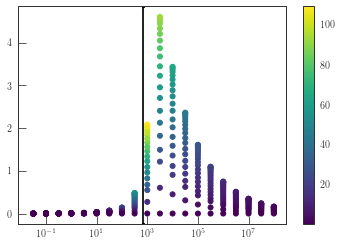

In [201]:

X = np.mean(ruwe, axis=1)
Y = np.mean(approx_ruwe, axis=1)
fig, ax = plt.subplots()
scat = ax.scatter(qPs.T[1], np.abs(Y - X), c=X)
ax.set_xscale("log")
ax.axvline(observing_span.to(u.day).value, c="k")
cbar = plt.colorbar(scat)

/Users/arc/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(0.9, 1.1)

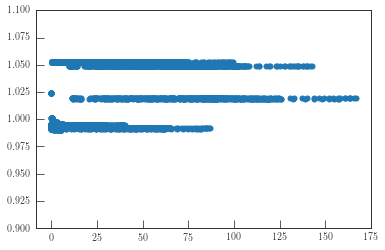

In [206]:
fig, ax = plt.subplots()
ax.scatter(ruwe, approx_ruwe/ruwe)
ax.set_ylim(0.9, 1.1)